## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

## Train
#model.fit(iris.data, iris.target)
## Extract single tree
#estimator = model.estimators_[5]
#
#from sklearn.tree import export_graphviz
## Export as dot file
#export_graphviz(estimator, out_file='tree.dot', 
#                feature_names = iris.feature_names,
#                class_names = iris.target_names,
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)
#
## Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
#
## Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
# check types.  Date objects need to be changed to date time.
df.dtypes

patient_id              int64
global_num            float64
sex                    object
birth_year            float64
age                    object
country                object
province               object
city                   object
disease                object
infection_case         object
infection_order       float64
infected_by           float64
contact_number        float64
symptom_onset_date     object
confirmed_date         object
released_date          object
deceased_date          object
state                  object
dtype: object

In [8]:
# convert confirmation date to datetime for age calculation
df['confirmed_date']= pd.to_datetime(df['confirmed_date'])
 
# Calculate age at time of confirmed infection
df['confirmed_year'] = df['confirmed_date'].dt.year
    
df['age']= df['confirmed_year']-df['birth_year']

df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,confirmed_year
0,1000000001,2.0,male,1964.0,56.0,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,2020.0
1,1000000002,5.0,male,1987.0,33.0,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,2020.0
2,1000000003,6.0,male,1964.0,56.0,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,2020.0
3,1000000004,7.0,male,1991.0,29.0,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,2020.0
4,1000000005,9.0,female,1992.0,28.0,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,2020.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    455
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
confirmed_year         141
dtype: int64

In [10]:
df['disease'].unique()



array([nan, True], dtype=object)

In [11]:
df['infection_case'].unique()


array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Pilgrimage to Israel'], dtype=object)

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [12]:
df.disease=df.disease.replace(True, 1)

df.disease = df['disease'].fillna(0)

df['disease'].unique()

array([0., 1.])

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [13]:
df.fillna(df.mean(), inplace=True)

C:\Users\ckitc\AppData\Local\Temp/ipykernel_56132/820435583.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)
C:\Users\ckitc\AppData\Local\Temp/ipykernel_56132/820435583.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [14]:
df.isnull().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                      0
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
confirmed_year           0
dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [15]:
df = df.fillna("Unknown")

In [16]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,confirmed_year
0,1000000001,2.0,male,1964.0,56.0,Korea,Seoul,Gangseo-gu,0.0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23 00:00:00,2020-02-05,Unknown,released,2020.0
1,1000000002,5.0,male,1987.0,33.0,Korea,Seoul,Jungnang-gu,0.0,overseas inflow,1.0,2.600789e+09,31.0,Unknown,2020-01-30 00:00:00,2020-03-02,Unknown,released,2020.0
2,1000000003,6.0,male,1964.0,56.0,Korea,Seoul,Jongno-gu,0.0,contact with patient,2.0,2.002000e+09,17.0,Unknown,2020-01-30 00:00:00,2020-02-19,Unknown,released,2020.0
3,1000000004,7.0,male,1991.0,29.0,Korea,Seoul,Mapo-gu,0.0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30 00:00:00,2020-02-15,Unknown,released,2020.0
4,1000000005,9.0,female,1992.0,28.0,Korea,Seoul,Seongbuk-gu,0.0,contact with patient,2.0,1.000000e+09,2.0,Unknown,2020-01-31 00:00:00,2020-02-24,Unknown,released,2020.0


Remove date columns from the data.


In [17]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [18]:
df.isnull().sum()

patient_id         0
global_num         0
sex                0
birth_year         0
age                0
country            0
province           0
city               0
disease            0
infection_case     0
infection_order    0
infected_by        0
contact_number     0
state              0
confirmed_year     0
dtype: int64

Review the count of unique values by column.

In [19]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   3
birth_year           97
age                  97
country               4
province             17
city                135
disease               2
infection_case       17
infection_order       7
infected_by         207
contact_number       73
state                 4
confirmed_year        1
dtype: int64


Review the percent of unique values by column.

In [20]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.001353
birth_year         0.043733
age                0.043733
country            0.001803
province           0.007665
city               0.060866
disease            0.000902
infection_case     0.007665
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
confirmed_year     0.000451
dtype: float64


Review the range of values per column.

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
age,2218.0,4.499716e+01,1.730309e+01,0.000000e+00,3.200000e+01,4.499716e+01,5.500000e+01,1.040000e+02
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
confirmed_year,2218.0,2.020000e+03,0.000000e+00,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03


### Check for duplicated rows

In [22]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,confirmed_year


Print the categorical columns and their associated levels.

In [28]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
print(dfo.shape)
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

(2218, 6)


,VarName,LevelsCount
0,sex,3
1,country,4
2,province,17
3,city,135
4,infection_case,17
5,state,4


**<font color='teal'> Plot the correlation heat map for the features.</font>**

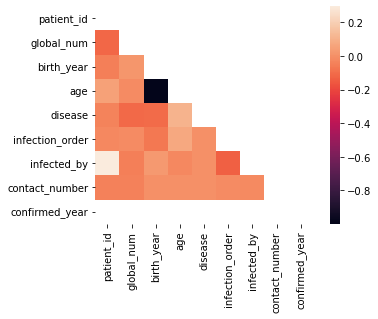

In [41]:
import seaborn as sns
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, square=True)

In [42]:
df.corr()

,patient_id,global_num,birth_year,age,disease,infection_order,infected_by,contact_number,confirmed_year
patient_id,1.000000,-0.115774,-0.052142,0.051457,-3.822030e-02,-2.728051e-02,2.963213e-01,-4.609026e-02,NaN
global_num,-0.115774,1.000000,0.014039,-0.014006,-1.088897e-01,-1.496382e-02,-5.265407e-02,-4.289483e-02,NaN
birth_year,-0.052142,0.014039,1.000000,-0.999530,-1.039651e-01,-6.883478e-02,2.701688e-02,1.433662e-03,NaN
age,0.051457,-0.014006,-0.999530,1.000000,1.040861e-01,6.995835e-02,-2.577577e-02,-1.433870e-03,NaN
disease,-0.038220,-0.108890,-0.103965,0.104086,1.000000e+00,3.781665e-16,-1.608674e-16,-1.374432e-17,NaN
infection_order,-0.027281,-0.014964,-0.068835,0.069958,3.781665e-16,1.000000e+00,-1.374471e-01,-1.601407e-02,NaN
infected_by,0.296321,-0.052654,0.027017,-0.025776,-1.608674e-16,-1.374471e-01,1.000000e+00,-2.179920e-02,NaN
contact_number,-0.046090,-0.042895,0.001434,-0.001434,-1.374432e-17,-1.601407e-02,-2.179920e-02,1.000000e+00,NaN
confirmed_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df.dtypes

patient_id           int64
global_num         float64
sex                 object
birth_year         float64
age                float64
country             object
province            object
city                object
disease            float64
infection_case      object
infection_order    float64
infected_by        float64
contact_number     float64
state               object
confirmed_year     float64
dtype: object

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

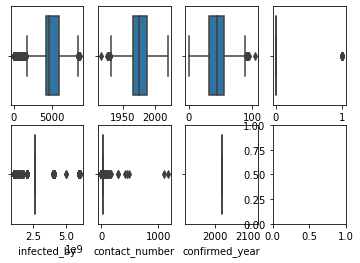

In [65]:
import numpy as np; np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

numerics=df.select_dtypes(include=['float64'])
fig, axes = plt.subplots(2, 4)

sns.boxplot(data=numerics, x='global_num', ax=axes[0,0])
sns.boxplot(data=numerics, x='birth_year', ax=axes[0,1])
sns.boxplot(data=numerics, x='age', ax=axes[0,2])
sns.boxplot(data=numerics, x='disease', ax=axes[0,3])
sns.boxplot(data=numerics, x='infected_by', ax=axes[1,0])
sns.boxplot(data=numerics, x='contact_number', ax=axes[1,1])
sns.boxplot(data=numerics, x='confirmed_year', ax=axes[1,2])


plt.show()

In [55]:
numerics.head()

,global_num,birth_year,age,disease,infection_order,infected_by,contact_number,confirmed_year
0,2.0,1964.0,56.0,0.0,1.0,2.600789e+09,75.0,2020.0
1,5.0,1987.0,33.0,0.0,1.0,2.600789e+09,31.0,2020.0
2,6.0,1964.0,56.0,0.0,2.0,2.002000e+09,17.0,2020.0
3,7.0,1991.0,29.0,0.0,1.0,2.600789e+09,9.0,2020.0
4,9.0,1992.0,28.0,0.0,2.0,1.000000e+09,2.0,2020.0


In [69]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,confirmed_year
0,1000000001,2.0,male,1964.0,56.0,Korea,Seoul,Gangseo-gu,0.0,overseas inflow,1.0,2.600789e+09,75.0,released,2020.0
1,1000000002,5.0,male,1987.0,33.0,Korea,Seoul,Jungnang-gu,0.0,overseas inflow,1.0,2.600789e+09,31.0,released,2020.0
2,1000000003,6.0,male,1964.0,56.0,Korea,Seoul,Jongno-gu,0.0,contact with patient,2.0,2.002000e+09,17.0,released,2020.0
3,1000000004,7.0,male,1991.0,29.0,Korea,Seoul,Mapo-gu,0.0,overseas inflow,1.0,2.600789e+09,9.0,released,2020.0
4,1000000005,9.0,female,1992.0,28.0,Korea,Seoul,Seongbuk-gu,0.0,contact with patient,2.0,1.000000e+09,2.0,released,2020.0


**<font color='teal'> Create dummy features for object type features. </font>**

In [73]:
X= df.drop(['patient_id','global_num','infected_by','contact_number','state'],axis =1)
X = pd.get_dummies(X)

y=df.state




In [74]:
X.head()

,birth_year,age,disease,infection_order,confirmed_year,sex_Unknown,sex_female,sex_male,country_China,country_Korea,...,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_Unknown,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1964.0,56.0,0.0,1.0,2020.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1987.0,33.0,0.0,1.0,2020.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1964.0,56.0,0.0,2.0,2020.0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1991.0,29.0,0.0,1.0,2020.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1992.0,28.0,0.0,2.0,2020.0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


### Split the data into test and train subsamples

In [75]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [76]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [77]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [78]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.824
Random Forest: f1-score=0.792


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [79]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[ 11   0   5   1]
 [  0   5   2   0]
 [  1   0 338  12]
 [  0   0  57  12]]
Normalized confusion matrix
[[0.65 0.   0.29 0.06]
 [0.   0.71 0.29 0.  ]
 [0.   0.   0.96 0.03]
 [0.   0.   0.83 0.17]]


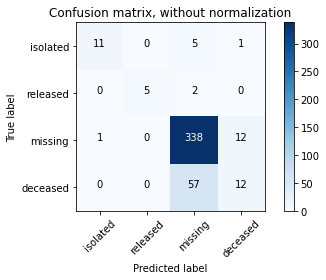

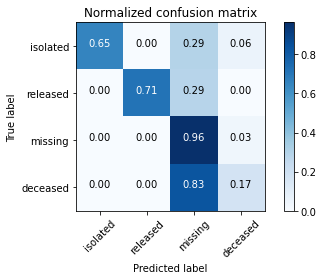

In [80]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


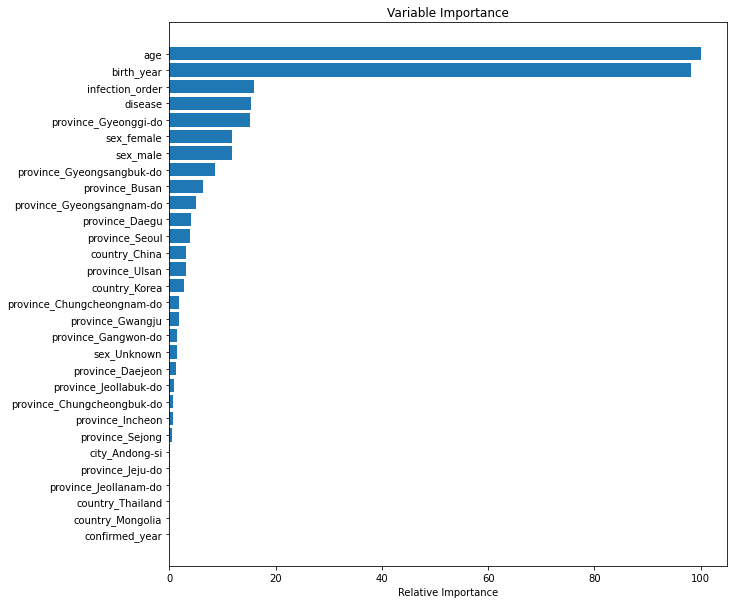

In [81]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.